# Basic Description of Cosine Similarity

Cosine similarity is, in simple terms, taking the angle between two vectors. In machine learning, cosine similarity can be used to measure how similar two documents are by counting how many times every word appears in a document; these word counts are then put into a vector (1 x n matrix). After two documents have their word counts put into a vector, compare the two documents by calculating the angle between the two vectors by using cosine, which can also be calculated in a vector space by using the following equations:

$cos(\theta) = \dfrac{A\cdot B}{\parallel A\parallel \parallel B\parallel}$ = $\dfrac{\sum_{i=1}^{n}A_i B_i}{\sqrt{\sum_{i=1}^{n}A_i^2}\sqrt{\sum_{i=1}^{n}B_i^2}}$

Which is the dot product of the two vectors divided by each vector's euclidean distance multiplied together.

* The dot product of two vectors can be defined in the algebraic sense as $A\cdot B = A_1B_1 + A_2B_2 + \dots + A_nB_n$

* In a geometric sense, the dot product can be defined as $A\cdot B = \parallel A \parallel \parallel B \parallel cos(\theta)$



The euclidean norm or euclidean distance is the ordinary distance from the origin to the point x.

* Euclidean distance of x: $\parallel x \parallel = \sqrt{x_1^2 + x_2^2 + \dots + x_n^2}$

Knowing all of this, cosine similarity is the algebraic definition of dot product divided by the two vector's euclidean distances to get the $cos(\theta)$ that resides in the geometric definition of dot product.

In [1]:
import requests
from bs4 import BeautifulSoup

#The data is from IMDB
url = "https://www.imdb.com/search/title/?genres=Adventure&sort=user_rating,desc&title_type=feature&num_votes=25000,&pf_rd_m=A2FGELUUNOQJNL&pf_rd_p=5aab685f-35eb-40f3-95f7-c53f09d542c3&pf_rd_r=N97GEQS6R7J9EV7V770D&pf_rd_s=right-6&pf_rd_t=15506&pf_rd_i=top&ref_=chttp_gnr_16"

# Sending a request to the speciifed URL
resp = requests.get(url)

# Converting the response to Beautiful Soup Object
content = BeautifulSoup(resp.content, 'lxml')

# Iterating through the list of movies and putting the titles and descriptions into lists.
title = []
desc = []
for movie in content.select('.lister-item-content'):
    try:
        title.append(movie.select('.lister-item-header')[0].get_text().strip())
        desc.append(movie.select('.text-muted')[2].get_text().strip())
    except IndexError:
        continue

# #Removing stop words from every description. Keep titles as is.
stopWords = ['the','to','a','from','as','the','with','and','in','of','but','for','it','was','have','on','that','with','at','is','are','be','or','he','his','we','not','has','they','its','by']
temp = []
for i in desc:
    querywords = i.split()
    resultWords=[word for word in querywords if word.lower() not in stopWords]
    join = ' '.join(resultWords)
    temp.append(join)
    
desc=temp

In [2]:
#Example of a movie title
title[49]

'50.\nQueen\n(2013)'

In [3]:
#Example of a movie description without stop words
desc[49]

'Delhi girl traditional family sets out solo honeymoon after her marriage gets cancelled.'

In [4]:
import math
import re  #Regular expression operations for unpacking documents
from collections import Counter

#compiles words (\w) into a regular expression object
WORD = re.compile(r"\w+")


#Takes in two vectors, finds the angle between them using cosine
def cosSimilarity(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numer = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denom = math.sqrt(sum1) * math.sqrt(sum2)

    if not denom:
        return 0.0
    else:
        return float(numer) / denom


#Counts every word in a document, returns a vector with the counts of each word
def textToVector(text):
    words = WORD.findall(text)
    return Counter(words)

In [5]:
import numpy as np
from decimal import *

#Cap the number of documents taken into matrix, x=y to keep matrix square
x = 7
y = 7

#The matrix that will store all of the cosine similarity values
matrix = np.full((x,y),1).astype('float')

In this case, I changed the similarity metric into the dissimilarity metric. This is because all linkage (max, single, etc.) uses dissimilarity. Changing similarity to dissimilarity in the (dissimilarity = 1 - similarity) way is possible when the similarity metric is between [-1,1]. Since my cosine similarity implementation uses the definition of cosine similarity, its range is [-1,1] and I am able to convert similarity to dissimilarity in this way. The range of dissimilarity is generally [0,infinity], but in this case the range is [0,2].

In [6]:
#Put all of the cosine similarities into the matrix
#Disimilarity between one document and itself will always be 0.

for i in range(x):
    for j in range(y):
        vec1 = textToVector(desc[i])
        vec2 = textToVector(desc[j])
        
        #Use 1-similarity to get dissimilarity, round number to 5 decimals
        temp = round(1-cosSimilarity(vec1,vec2),5)
        matrix[i][j] = temp

### Description of Max Linkage

Hierarchical cluster analysis is an unsupervised clustering algorithm that tries to build a hierarchy of clusters. The dataset I will be working with has a diagonal of zeroes. The values are also reflected across the diagonal. Matrices such as this are known as distance matrices. Each value is the dissimilarity value of two samples, 1 and the sample in question. For example, the first column and first row sample would be the dissimilarity value between 1 and 1, which is zero. The grid including 1, 2, 3, etc. is shown in the dendrogram graph.

The algorithm starts by finding the minimum value in the dataset. There should be at least 2 since the data is reflected across the diagonal. Then the value on the left side of the diagonal searches for the largest value in its row. The value on the left side of the diagonal searches for the largest value in its column. If the dataset is made correctly and the algorithm worked correctly, these two largest values should be the same. The minumum value is replaced with the found largest value. This largest value now represents the dissimilarity value between A and the row and column that were searched through. Then the row and column that were searched through are deleted, and the process begins again. This process is repeated until there is only a two by two square left which houses the maximum dissimilarity value. 

The clustering portion of this algorithm becomes more clear when the deleted rows and columns are summarized in a dendrogram. 

In [8]:
import numpy as np

def maxLinkage(data):
    data=np.array(data)
    iter = 0
    
    #Continue until there are only two columns
    while(len(data[0])>2):
        
        #Remove zeroes from list to find min
        listNoZeroes = np.ma.masked_equal(data, 0.0, copy=False)
        
        #Find minimum value
        least = listNoZeroes.min()
        index = np.where(data==least)
        
        #Change rows to max value between the two rows
        #Notice that the data will always be a square
        for z in range(len(data[0])):
            if(data[index[0][0]][z]!=0):
                data[index[0][0]][z] = max(data[index[0][0]][z], data[index[1][0]][z])
                
        #Change columns to max value between two columns
        for z in range(len(data[0])):
            if(data[z][index[0][0]]!=0):
                data[z][index[0][0]] = max(data[z][index[0][0]], data[z][index[1][0]])
                
        #Delete row and column where min value was
        data = np.delete(data,index[1][0], 0)
        data = np.delete(data,index[1][0], 1)
        
        print('Iteration: ', iter)
        print(data)
        print()
        iter +=1
        
    return data

In [9]:
def plot_dendrogram(model, labelled, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    plot = dendrogram(linkage_matrix, **kwargs, labels = labelled)

C:\Users\zacki\anaconda3\lib\site-packages\sklearn\cluster\_agglomerative.py:492: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Original
[[-0.       0.95623  1.       0.96491  0.95948  1.       0.95623]
 [ 0.95623 -0.       1.       1.       0.74283  0.83333  0.94444]
 [ 1.       1.       0.       1.       0.95348  1.       1.     ]
 [ 0.96491  1.       1.       0.       1.       1.       0.95546]
 [ 0.95948  0.74283  0.95348  1.       0.       0.94857  0.94857]
 [ 1.       0.83333  1.       1.       0.94857 -0.       1.     ]
 [ 0.95623  0.94444  1.       0.95546  0.94857  1.      -0.     ]]

Iteration:  0
[[-0.       0.95948  1.       0.96491  1.       0.95623]
 [ 0.95948 -0.       1.       1.       0.94857  0.94857]
 [ 1.       1.       0.       1.       1.       1.     ]
 [ 0.96491  1.       1.       0.       1.       0.95546]
 [ 1.       0.94857  1.       1.      -0.       1.     ]
 [ 0.95623  0.94857  1.       0.95546  1.      -0.     ]]

Iteration:  1
[[-0.       1.       1.       0.96491  0.95623]
 [ 1.      -0.       1.       1.       1.     ]
 [ 1.       1.       0.       1.       1.     ]
 [ 0.96491 

array([[-0.,  1.],
       [ 1.,  0.]])

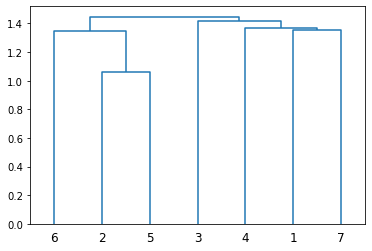

In [10]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

#Dendrogram graph
labels = []
for i in range(1,x+1):
    labels.append(i)
cluster = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage = 'complete').fit(matrix)
plot = plot_dendrogram(cluster, truncate_mode="level", p=3, labelled = labels)


print('Original')
print(np.array(matrix))
print()
maxLinkage(matrix)

In [11]:
for i in range(x):
    print(title[i])
    print()

1.
Kantara
(2022)

2.
The Lord of the Rings: The Return of the King
(2003)

3.
777 Charlie
(2022)

4.
Inception
(2010)

5.
The Lord of the Rings: The Two Towers
(2002)

6.
The Lord of the Rings: The Fellowship of the Ring
(2001)

7.
The Good, the Bad and the Ugly
(1966)



### Interpreting the Dendrogram

In this dendrogram, it can be seen that every movie description is dissimilar to each other by the height of the graph. The most similar movies are LOTR Return of the King and LOTR The Two Towers. In that same cluster is LOTR Fellowship of the Ring. In the other cluster, the most similar movie descriptions are Kantara and the Good the Bad and the Ugly. It can be seen that there are two clusters. One consists of all the LOTR movies, and the other cluster has the rest of the movies.

This is how to interpret a dendrogram.

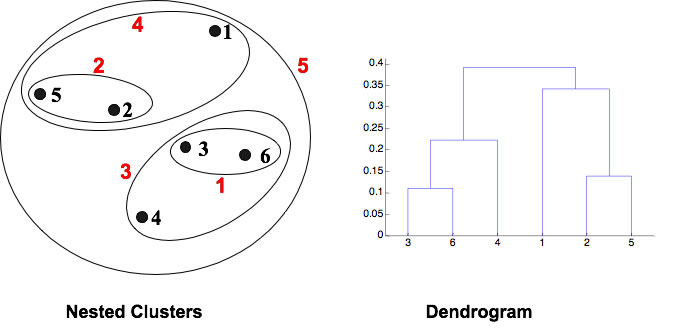